In [1]:
import sys
import os

SCRIPT_PATH = os.path.join(os.path.abspath(os.path.dirname('../__file__')), 'script')
sys.path.insert(0, SCRIPT_PATH)

from markov_device import *
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

ACT-R connection has been started.


# Compare MB vs. MF


In this analysis notebook, we're gonna compare the performance of two models from x following aspects

- P(stay)
- rewards gained
- utility trace

## Stay Probability

RL Hypothesis:
![RL P(Stay)](https://www.ncbi.nlm.nih.gov/pmc/articles/instance/3077926/bin/nihms280176f2.jpg)

In [2]:
def simulate_response_monkey(model="markov-monkey", epoch=1, n=20):
    rewards = 0.0 
    beh_list, state1stay_list = [], []
    
    for i in tqdm(range(epoch)):
        m = MarkovHuman(model, verbose=False)
        m.run_experiment(n)
        if (i==0): print(m)
        m.run_experiment(n) 
        
        
        state1stay = m.calculate_stay_probability()
        beh = df_behavior(m)
        state1stay['epoch'] = i 
        beh['epoch'] = i
        
        beh_list.append(beh)
        state1stay_list.append(state1stay.groupby(['epoch', 'received_reward', 'reward_frequency', 'state_frequency']).agg({'state1_stay': lambda x: x.mean(skipna=True)}).reset_index())
 
        rewards += beh['received_reward'].sum()/len(beh)
    
    max_id = np.argmax(list(m.task_parameters['REWARD_PROBABILITY'].values()))
    expected_reward= list(m.task_parameters['REWARD'].values())[max_id] * list(m.task_parameters['REWARD_PROBABILITY'].values())[max_id]
    print('--- simulation ---', epoch)
    print('mean reward = %.2f (out of %.2f)' % ((rewards/epoch), expected_reward) )
    df_beh = pd.concat(beh_list, axis=0)
    df_state1stay = pd.concat(state1stay_list, axis=0)
    return df_beh, df_state1stay

def simulate_stay_probability(model="markov-model1", epoch=1, n=20, task_params=None, actr_params=None):
    rewards = 0.0 
    beh_list, state1stay_list, utrace_list, atrace_list = [], [], [], []
    
    for i in tqdm(range(epoch)):
        m = MarkovACTR(setup=False) 
        m.setup(model, verbose=False, 
                task_params=task_params,
                actr_params=actr_params)
        if (i==0): print(m)
        m.run_experiment(n)
        
        # stay probability
        state1stay = m.calculate_stay_probability()
        utrace, atrace = df_trace(m)
        beh = df_behavior(m)
        state1stay['epoch'] = i
        utrace['epoch'] = i
        atrace['epoch'] = i
        beh['epoch'] = i
        
        beh_list.append(beh)
        state1stay_list.append(state1stay.groupby(['epoch', 'received_reward', 'reward_frequency', 'state_frequency']).agg({'state1_stay': lambda x: x.mean(skipna=True)}).reset_index())
        utrace_list.append(utrace.groupby(['epoch', 'index_bin', 'action', 'state', 'response']).agg({':utility': lambda x: x.max(skipna=True)}).reset_index())
        atrace_list.append(atrace.groupby(['epoch', 'index_bin', 'memory', 'memory_type']).agg({':Reference-Count': lambda x: x.max(skipna=True),
                                                                                 ':Last-Retrieval-Activation': lambda x: x.max(skipna=True)}).reset_index())
        
        
        # plot 
        rewards += beh['received_reward'].sum()/len(beh)
        
    
    max_id = np.argmax(list(m.task_parameters['REWARD_PROBABILITY'].values()))
    expected_reward= list(m.task_parameters['REWARD'].values())[max_id] * list(m.task_parameters['REWARD_PROBABILITY'].values())[max_id]
    print('--- simulation ---', epoch)
    print('mean reward = %.2f (out of %.2f)' % ((rewards/epoch), expected_reward) )
    df_beh = pd.concat(beh_list, axis=0)
    df_state1stay = pd.concat(state1stay_list, axis=0)
    df_utrace = pd.concat(utrace_list, axis=0)
    df_atrace = pd.concat(atrace_list, axis=0)
    return df_beh, df_state1stay, df_utrace, df_atrace

def df_trace(m):     
    
    # production trace
    df1 = m.df_actr_production_traces(parameter_name=':utility') 
    df1['index_bin'] = pd.cut(df1['index'], 10, labels=False, ordered=False, right=False)
    df1['state'] = df1.apply(lambda x: 'STATE1' if ('CHOOSE-STATE1' in x['action']) else 'STATE2', axis=1)
    df1['response'] = df1.apply(lambda x: 'LEFT' if ('LEFT' in x['action']) else 'RIGHT', axis=1)
    df1 = df1.fillna(0.0)
    
    # memory trace
    try: 
        df21 = m.df_actr_chunk_traces(parameter_name=':Reference-Count')
        df22 = m.df_actr_chunk_traces(parameter_name=':Last-Retrieval-Activation').fillna(0.0)
        df2 = pd.merge(df21, df22)  
        df2['index_bin'] = pd.cut(df2['index'], 10, labels=False)  
        df2.replace(to_replace=[None], value=np.nan, inplace=True)
        #df2['memory_type'] = df2.apply(lambda x: 'non-reward' if 'M0' in x['memory'] else 'reward', axis=1) 
        df2['memory_type'] = 'non-reward'
        df2.loc[df2['memory'].str.endswith(('B1', 'B3', 'C1', 'C3')), 'memory_type'] = 'reward'
    except:
        print('no memory trace')
        df2 = None
    finally:
        df1 = df1.astype({'index_bin':float, ':utility':float})  
        df2 = df2.astype({'index_bin':float, ':Reference-Count':float, ':Last-Retrieval-Activation':float})  
        return df1, df2 
    
def df_behavior(m):
    df = m.df_behaviors().reset_index()
    df['index_bin'] = pd.cut(df['index'], 10, labels=False, ordered=False, right=False)
    df['received_reward_sum'] = df['received_reward'].cumsum()
    df['optimal_response_sum'] = df.apply(lambda x:x['state1_response']=='f' and x['state2_response']=='k', axis=1).cumsum() 
    return df

In [3]:
task_params={'REWARD': {'B1': 10, 'B2': 10, 'C1': 10, 'C2': 10}}
actr_params={'seed':'[100, 0]',  'ans': 0.2, 'egs':0.2, 'lf':0.5, 'bll':0.5}
e=2
n=50

In [4]:
df0, df0_state1stay = simulate_response_monkey(model='markov-left', epoch=e, n=n)
df1, df1_state1stay, df1_utrace, df1_atrace = simulate_stay_probability(model="markov-model1", epoch=e, n=n, task_params=task_params, actr_params=actr_params)
df2, df2_state1stay, df2_utrace, df2_atrace = simulate_stay_probability(model="markov-model2", epoch=e, n=n, task_params=task_params, actr_params=actr_params)
df3, df3_state1stay, df3_utrace, df3_atrace = simulate_stay_probability(model="markov-model3", epoch=e, n=n, task_params=task_params, actr_params=actr_params)

  0%|          | 0/2 [00:00<?, ?it/s]

######### SETUP MODEL markov-left #########
{'MARKOV_PROBABILITY': 0.7, 'REWARD_PROBABILITY': {'B1': 0.1, 'B2': 0.7, 'C1': 0.2, 'C2': 0.4}, 'REWARD': {'B1': 2, 'B2': 2, 'C1': 2, 'C2': 2}}
--- simulation --- 2
mean reward = 0.26 (out of 1.40)
######### SETUP MODEL markov-model1 #########
 	>> TASK PARAMETERS: {'MARKOV_PROBABILITY': 0.7, 'REWARD_PROBABILITY': {'B1': 0.1, 'B2': 0.7, 'C1': 0.2, 'C2': 0.4}, 'REWARD': {'B1': 10, 'B2': 10, 'C1': 10, 'C2': 10}} <<
 	>> ACT-R PARAMETERS: {'v': None, 'seed': '[100, 0]', 'ans': 0.2, 'lf': 0.5, 'bll': 0.5, 'mas': None, 'egs': 0.2, 'alpha': 0.2, 'imaginal-activation': 1.0} <<



  0%|          | 0/2 [00:00<?, ?it/s]

--- simulation --- 2
mean reward = 6.10 (out of 7.00)
######### SETUP MODEL markov-model2 #########
 	>> TASK PARAMETERS: {'MARKOV_PROBABILITY': 0.7, 'REWARD_PROBABILITY': {'B1': 0.1, 'B2': 0.7, 'C1': 0.2, 'C2': 0.4}, 'REWARD': {'B1': 10, 'B2': 10, 'C1': 10, 'C2': 10}} <<
 	>> ACT-R PARAMETERS: {'v': None, 'seed': '[100, 0]', 'ans': 0.2, 'lf': 0.5, 'bll': 0.5, 'mas': None, 'egs': 0.2, 'alpha': 0.2, 'imaginal-activation': 1.0} <<



  0%|          | 0/2 [00:00<?, ?it/s]

--- simulation --- 2
mean reward = 6.60 (out of 7.00)
######### SETUP MODEL markov-model3 #########
 	>> TASK PARAMETERS: {'MARKOV_PROBABILITY': 0.7, 'REWARD_PROBABILITY': {'B1': 0.1, 'B2': 0.7, 'C1': 0.2, 'C2': 0.4}, 'REWARD': {'B1': 10, 'B2': 10, 'C1': 10, 'C2': 10}} <<
 	>> ACT-R PARAMETERS: {'v': None, 'seed': '[100, 0]', 'ans': 0.2, 'lf': 0.5, 'bll': 0.5, 'mas': None, 'egs': 0.2, 'alpha': 0.2, 'imaginal-activation': 1.0} <<



100%|██████████| 2/2 [00:14<00:00,  7.37s/it]

--- simulation --- 2
mean reward = 4.00 (out of 7.00)


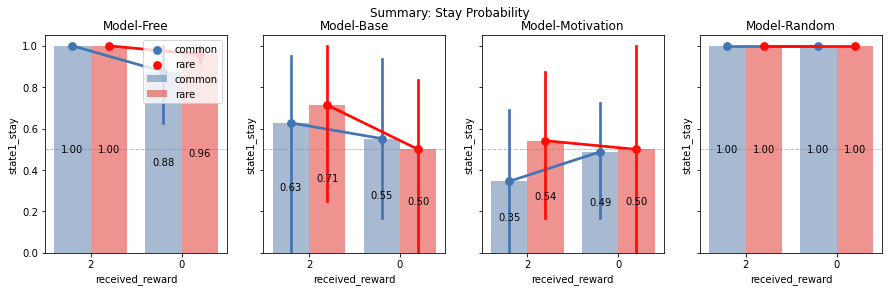

In [5]:
# Create an array with the colors you want to use
my_palette = sns.color_palette(["#4374B3", "#FF0B04"])

fig, axes = plt.subplots(1, 4, figsize=(15,4), sharex=True, sharey=True)
fig.suptitle('Summary: Stay Probability')
sns.barplot(data=df1_state1stay, x='received_reward', y='state1_stay', 
            hue='state_frequency', 
            palette=my_palette, alpha=.5, 
            order = sorted(df1_state1stay['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'], errorbar=None,
            ax=axes[0]) 
sns.pointplot(data=df1_state1stay, x='received_reward', y='state1_stay', dodge=0.4,
            hue='state_frequency', 
              palette=my_palette, 
            order = sorted(df1_state1stay['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'],
            ax=axes[0]) 

sns.barplot(data=df2_state1stay, x='received_reward', y='state1_stay',
            hue='state_frequency', palette=my_palette, alpha=.5,
            order = sorted(df2_state1stay['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'], errorbar=None,
            ax=axes[1]) 
sns.pointplot(data=df2_state1stay, x='received_reward', y='state1_stay',  dodge=0.4,
            hue='state_frequency', 
            palette=my_palette, 
            order = sorted(df2_state1stay['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'],
            ax=axes[1]) 

sns.barplot(data=df3_state1stay, x='received_reward', y='state1_stay',
            hue='state_frequency', palette=my_palette, alpha=.5,
            order = sorted(df3_state1stay['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'], errorbar=None,
            ax=axes[2]) 
sns.pointplot(data=df3_state1stay, x='received_reward', y='state1_stay',  dodge=0.4,
            hue='state_frequency', 
            palette=my_palette, 
            order = sorted(df3_state1stay['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'],
            ax=axes[2]) 

sns.barplot(data=df0_state1stay, x='received_reward', y='state1_stay',
            hue='state_frequency', palette=my_palette, alpha=.5,
            order = sorted(df0_state1stay['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'], errorbar=None,
            ax=axes[3]) 
sns.pointplot(data=df0_state1stay, x='received_reward', y='state1_stay',  dodge=0.4,
            hue='state_frequency', 
            palette=my_palette, 
            order = sorted(df0_state1stay['received_reward'].unique(), reverse=True), 
            hue_order=['common', 'rare'],
            ax=axes[3]) 

for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='center')
    ax.axhline(0.5, color='grey', ls='-.', linewidth=.5)    

    

axes[0].legend(loc=1)
axes[1].legend_.remove()
axes[2].legend_.remove()
axes[3].legend_.remove()
axes[0].set_title('Model-Free')
axes[1].set_title('Model-Base')
axes[2].set_title('Model-Motivation')
axes[3].set_title('Model-Random')

plt.show()

## Utility Trace

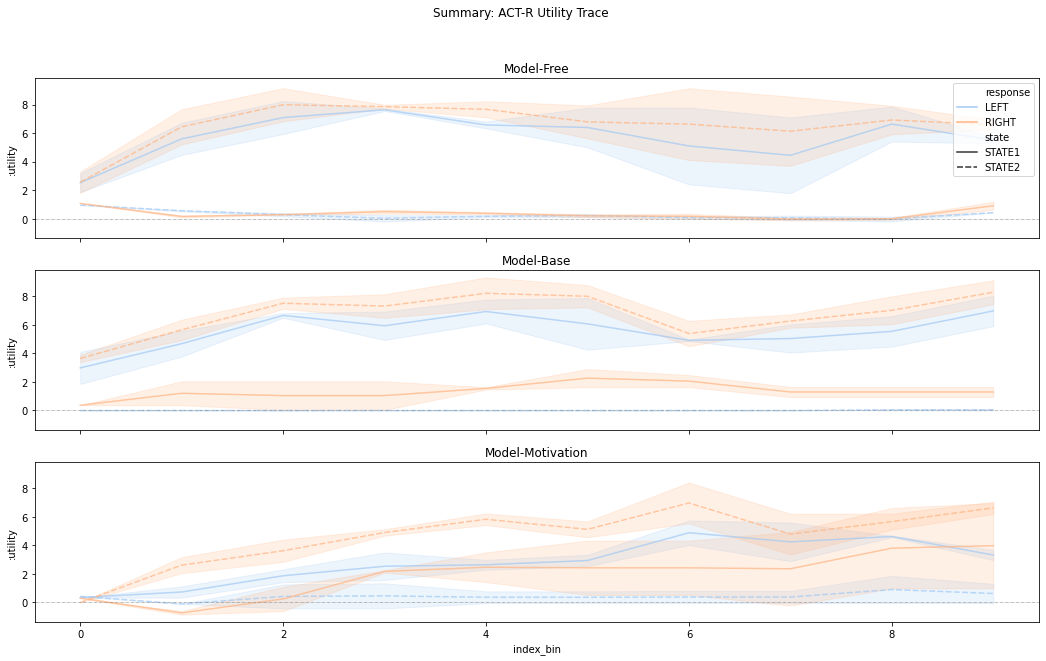

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(18,10), sharex=True, sharey=True)
fig.suptitle('Summary: ACT-R Utility Trace')

sns.lineplot(data = df1_utrace, x='index_bin', y=':utility', hue='response', style="state", alpha=.7, palette='pastel', ax=axes[0])
sns.lineplot(data = df2_utrace, x='index_bin', y=':utility', hue='response', style="state", alpha=.7, palette='pastel', ax=axes[1], legend=None)
sns.lineplot(data = df3_utrace, x='index_bin', y=':utility', hue='response', style="state", alpha=.7, palette='pastel', ax=axes[2], legend=None)


axes[0].set_title('Model-Free')
axes[1].set_title('Model-Base')
axes[2].set_title('Model-Motivation')

axes[0].axhline(0, color='grey', ls='-.', linewidth=.5)
axes[1].axhline(0, color='grey', ls='-.', linewidth=.5)
axes[2].axhline(0, color='grey', ls='-.', linewidth=.5)

axes[0].legend(loc=1)
plt.show()

## U(Difference) Trace 

U(LEFT) - U(RIGHT)

In [7]:
def calculate_u_diff(df):
    """
    To better visualize the utility difference between two production, we could calculate U(L-R)
    """
    dff = df.pivot_table(columns=['action'], index=['index_bin', 'epoch'], fill_value=0.0)
    dff.columns = ['CHOOSE-STATE1-LEFT', 'CHOOSE-STATE1-RIGHT', 'CHOOSE-STATE2-LEFT', 'CHOOSE-STATE2-RIGHT']
    dff['STATE1'] = dff.apply(lambda x:x['CHOOSE-STATE1-LEFT']-x['CHOOSE-STATE1-RIGHT'], axis=1)
    dff['STATE2'] = dff.apply(lambda x:x['CHOOSE-STATE2-LEFT']-x['CHOOSE-STATE2-RIGHT'], axis=1)
    dff = dff[['STATE1', 'STATE2']].reset_index()
    df = dff.melt(id_vars=['epoch', 'index_bin'], var_name='state', value_name=':utility').astype({'epoch':float, 'index_bin':float, ':utility':float})   
    return df

In [8]:
df1_utrace_diff, df2_utrace_diff, df3_utrace_diff = calculate_u_diff(df1_utrace), calculate_u_diff(df2_utrace), calculate_u_diff(df3_utrace)

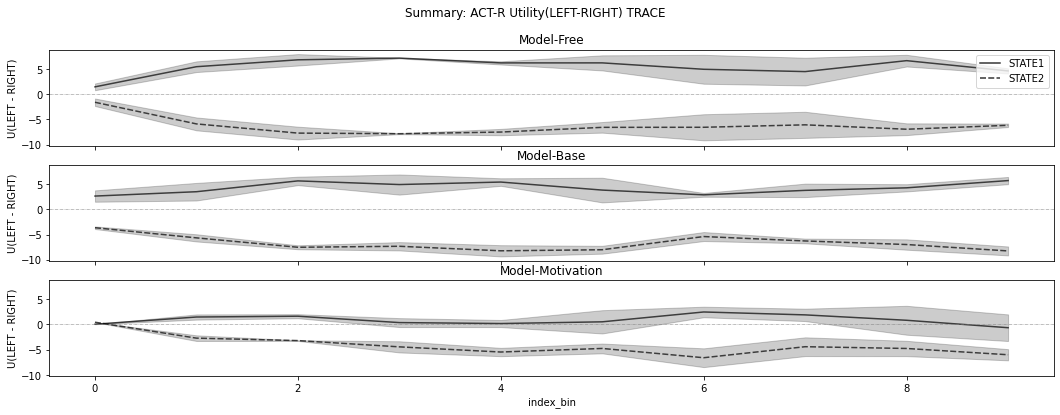

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(18,6), sharex=True, sharey=True)
fig.suptitle('Summary: ACT-R Utility(LEFT-RIGHT) TRACE')
sns.lineplot(data = df1_utrace_diff, x='index_bin', y=':utility', style="state", color='black', alpha=.7, ax=axes[0])
sns.lineplot(data = df2_utrace_diff, x='index_bin', y=':utility', style="state", color='black', alpha=.7, ax=axes[1], legend=None)
sns.lineplot(data = df3_utrace_diff, x='index_bin', y=':utility', style="state", color='black', alpha=.7, ax=axes[2], legend=None)


axes[0].set_title('Model-Free')
axes[1].set_title('Model-Base')
axes[2].set_title('Model-Motivation')
                  
axes[0].axhline(0, color='grey', ls='-.', linewidth=.5)
axes[1].axhline(0, color='grey', ls='-.', linewidth=.5)
axes[2].axhline(0, color='grey', ls='-.', linewidth=.5)

axes[0].legend(loc=1)
axes[0].set(ylabel='U(LEFT - RIGHT)')
axes[1].set(ylabel='U(LEFT - RIGHT)')
axes[2].set(ylabel='U(LEFT - RIGHT)')
plt.show()

## :Activation of DM

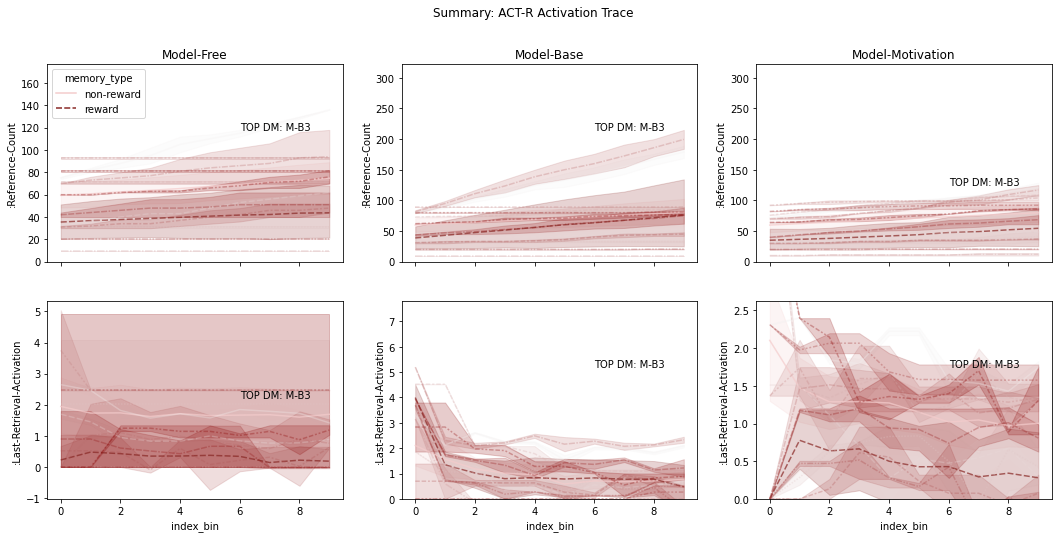

In [10]:
# Create an array with the colors you want to use
reward_palette1 = sns.color_palette(['#f4cccc', '#882724'])
reward_palette2 = sns.color_palette("light:darkred", n_colors=12) #sns.light_palette("salmon", reverse=True, as_cmap=True)

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=False)

fig.suptitle('Summary: ACT-R Activation Trace')
sns.lineplot(data = df1_atrace, x='index_bin', y=':Reference-Count', hue='memory_type', style='memory_type', alpha=.7, palette=reward_palette1, ax=axes[0][0])
sns.lineplot(data = df1_atrace, x='index_bin', y=':Reference-Count', hue='memory', style='memory', alpha=.3,  palette=reward_palette2, legend=None, ax=axes[0][0])

sns.lineplot(data = df1_atrace, x='index_bin', y=':Last-Retrieval-Activation', hue='memory_type', style='memory_type', alpha=.7, palette=reward_palette1, legend=None, ax=axes[1][0])
sns.lineplot(data = df1_atrace, x='index_bin', y=':Last-Retrieval-Activation', hue='memory', style='memory', alpha=.3,  palette=reward_palette2, legend=None, ax=axes[1][0])



sns.lineplot(data = df2_atrace, x='index_bin', y=':Reference-Count', hue='memory_type', style='memory_type', alpha=.7, palette=reward_palette1, legend=None, ax=axes[0][1])
sns.lineplot(data = df2_atrace, x='index_bin', y=':Reference-Count', hue='memory', style='memory', alpha=.3,  palette=reward_palette2, legend=None, ax=axes[0][1])

sns.lineplot(data = df2_atrace, x='index_bin', y=':Last-Retrieval-Activation', hue='memory_type', style='memory_type', alpha=.7, palette=reward_palette1, legend=None,  ax=axes[1][1])
sns.lineplot(data = df2_atrace, x='index_bin', y=':Last-Retrieval-Activation', hue='memory', style='memory', alpha=.3,  palette=reward_palette2, legend=None, ax=axes[1][1])



sns.lineplot(data = df3_atrace, x='index_bin', y=':Reference-Count', hue='memory_type', style='memory_type', alpha=.7, palette=reward_palette1, legend=None, ax=axes[0][2])
sns.lineplot(data = df3_atrace, x='index_bin', y=':Reference-Count', hue='memory', style='memory', alpha=.3,  palette=reward_palette2, legend=None, ax=axes[0][2])

sns.lineplot(data = df3_atrace, x='index_bin', y=':Last-Retrieval-Activation', hue='memory_type', style='memory_type', alpha=.7, palette=reward_palette1, legend=None, ax=axes[1][2])
sns.lineplot(data = df3_atrace, x='index_bin', y=':Last-Retrieval-Activation', hue='memory', style='memory', alpha=.3,  palette=reward_palette2, legend=None, ax=axes[1][2])



axes[0][0].set_title('Model-Free')
axes[0][1].set_title('Model-Base')
axes[0][2].set_title('Model-Motivation')


# annotation

df1_chunk_cnt = df1_atrace.groupby(['memory', 'memory_type'])[':Reference-Count'].max().reset_index().sort_values(by = ['memory_type', ':Reference-Count'], ascending=False).values[0]
df1_chunk_act = df1_atrace.groupby(['memory', 'memory_type'])[':Last-Retrieval-Activation'].max().reset_index().sort_values(by = ['memory_type', ':Last-Retrieval-Activation'], ascending=False).values[0]
df2_chunk_cnt = df2_atrace.groupby(['memory', 'memory_type'])[':Reference-Count'].max().reset_index().sort_values(by = ['memory_type', ':Reference-Count'], ascending=False).values[0]
df2_chunk_act = df2_atrace.groupby(['memory', 'memory_type'])[':Last-Retrieval-Activation'].max().reset_index().sort_values(by = ['memory_type', ':Last-Retrieval-Activation'], ascending=False).values[0]
df3_chunk_cnt = df3_atrace.groupby(['memory', 'memory_type'])[':Reference-Count'].max().reset_index().sort_values(by = ['memory_type', ':Reference-Count'], ascending=False).values[0]
df3_chunk_act = df3_atrace.groupby(['memory', 'memory_type'])[':Last-Retrieval-Activation'].max().reset_index().sort_values(by = ['memory_type', ':Last-Retrieval-Activation'], ascending=False).values[0]


axes[0][0].text(6, df1_chunk_cnt[-1], f'TOP DM: %s'% (df1_chunk_cnt[0]))
axes[1][0].text(6, df1_chunk_act[-1], f'TOP DM: %s'% (df1_chunk_act[0]))

axes[0][1].text(6, df2_chunk_cnt[-1], f'TOP DM: %s'% (df2_chunk_cnt[0]))
axes[1][1].text(6, df2_chunk_act[-1], f'TOP DM: %s'% (df2_chunk_act[0]))
axes[0][2].text(6, df3_chunk_cnt[-1], f'TOP DM: %s'% (df3_chunk_cnt[0]))
axes[1][2].text(6, df3_chunk_act[-1], f'TOP DM: %s'% (df3_chunk_act[0]))

axes[0][0].set_ylim(0, df1_chunk_cnt[-1]*1.5)
axes[0][1].set_ylim(0, df2_chunk_cnt[-1]*1.5)
axes[0][2].set_ylim(0, df2_chunk_cnt[-1]*1.5)
axes[1][1].set_ylim(0, df2_chunk_act[-1]*1.5)
axes[1][2].set_ylim(0, df3_chunk_act[-1]*1.5) 

plt.show()

## :Reference-Count of DM

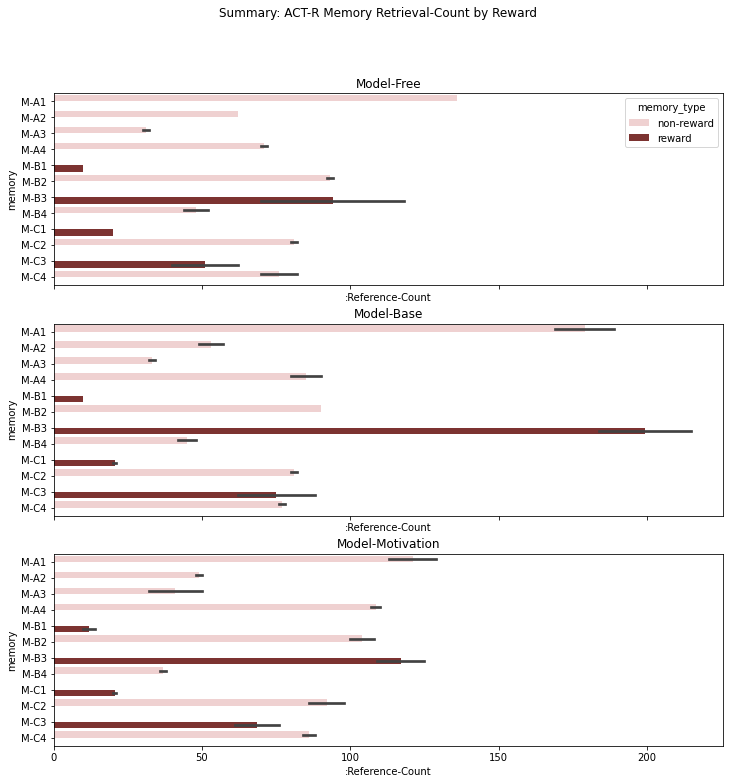

In [11]:
fig, axes = plt.subplots(3,1,figsize=(12, 12), sharex=True, sharey=True)
fig.suptitle('Summary: ACT-R Memory Retrieval-Count by Reward')

sns.barplot(data = df1_atrace[df1_atrace['index_bin'] == 9], x=':Reference-Count', y='memory', hue='memory_type', palette=reward_palette1, ax=axes[0])
sns.barplot(data = df2_atrace[df2_atrace['index_bin'] == 9], x=':Reference-Count', y='memory', hue='memory_type', palette=reward_palette1, ax=axes[1])
sns.barplot(data = df3_atrace[df3_atrace['index_bin'] == 9], x=':Reference-Count', y='memory', hue='memory_type', palette=reward_palette1, ax=axes[2])

axes[0].set_title('Model-Free')
axes[1].set_title('Model-Base')
axes[2].set_title('Model-Motivation')

axes[1].legend_.remove()
axes[2].legend_.remove()
plt.show()

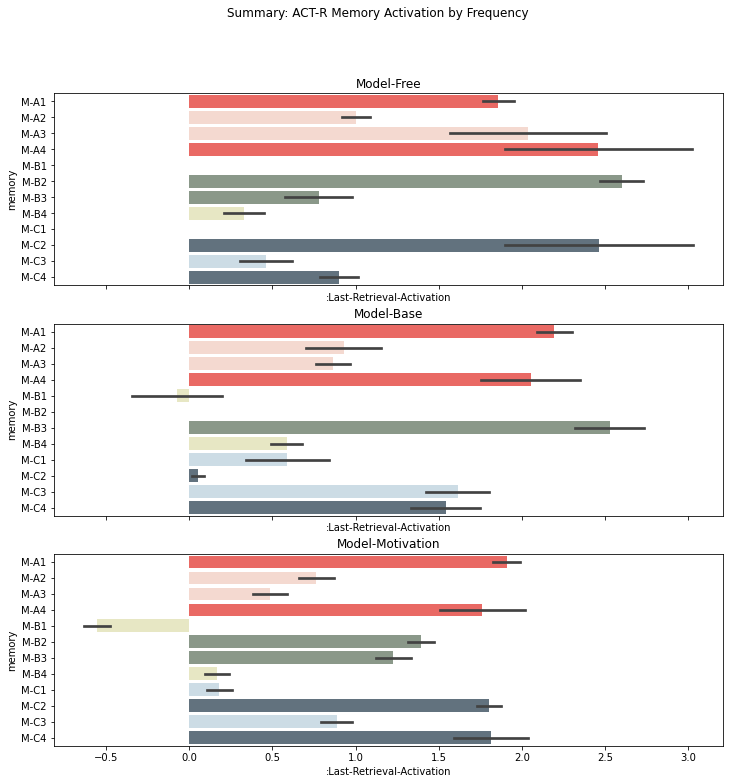

In [12]:
my_chunk_palette = sns.color_palette(["#FF0B04", "#F8C4B4", "#F8C4B4", "#FF0B04", "#E6E5A3", "#557153", "#557153", "#E6E5A3", "#B1D0E0", "#1A374D", "#B1D0E0", "#1A374D"])

fig, axes = plt.subplots(3,1,figsize=(12, 12), sharex=True, sharey=True)
fig.suptitle('Summary: ACT-R Memory Activation by Frequency')

sns.barplot(data =df1_atrace, y='memory', x=':Last-Retrieval-Activation', alpha=.7, palette=my_chunk_palette, errorbar='se', ax=axes[0])
sns.barplot(data =df2_atrace, y='memory', x=':Last-Retrieval-Activation', alpha=.7, palette=my_chunk_palette, errorbar='se', ax=axes[1])
sns.barplot(data =df3_atrace, y='memory', x=':Last-Retrieval-Activation', alpha=.7, palette=my_chunk_palette, errorbar='se', ax=axes[2])

axes[0].set_title('Model-Free')
axes[1].set_title('Model-Base')
axes[2].set_title('Model-Motivation')

plt.show()

## Learning Performance

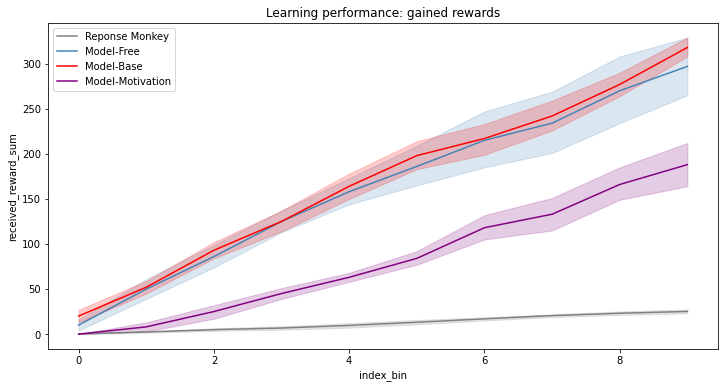

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax=sns.lineplot(data=df0, x='index_bin', y='received_reward_sum', label='Reponse Monkey', color='gray')
ax=sns.lineplot(data=df1, x='index_bin', y='received_reward_sum', label='Model-Free', color='steelblue')
ax=sns.lineplot(data=df2, x='index_bin', y='received_reward_sum', label='Model-Base', color='red')
ax=sns.lineplot(data=df3, x='index_bin', y='received_reward_sum', label='Model-Motivation', color='purple')
plt.title('Learning performance: gained rewards')
plt.show()

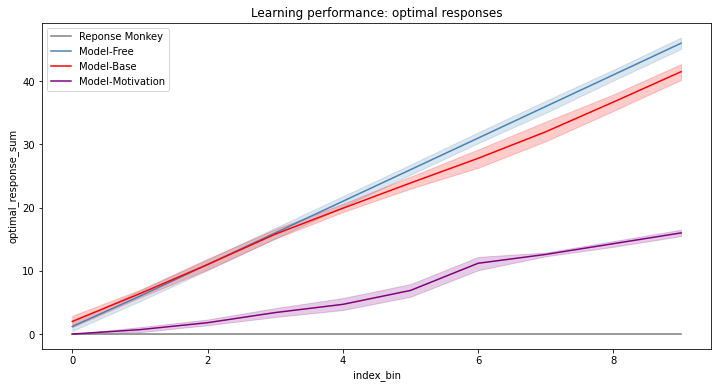

In [14]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

ax=sns.lineplot(data=df0, x='index_bin', y='optimal_response_sum', label='Reponse Monkey', color='gray')
ax=sns.lineplot(data=df1, x='index_bin', y='optimal_response_sum', label='Model-Free', color='steelblue')
ax=sns.lineplot(data=df2, x='index_bin', y='optimal_response_sum', label='Model-Base', color='red')
ax=sns.lineplot(data=df3, x='index_bin', y='optimal_response_sum', label='Model-Motivation', color='purple')
plt.title('Learning performance: optimal responses')
plt.show()